In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cot_probing import DATA_DIR
from cot_probing.typing import *
from transformers import AutoTokenizer
import pickle
import torch
import random
from tqdm.auto import tqdm, trange

model_id = "hugging-quants/Meta-Llama-3.1-8B-BNB-NF4-BF16"
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [3]:
with open("../activations/acts_oct28-1156.pkl", "rb") as f:
    activations = pickle.load(f)

In [4]:
fai_resid_acts_by_layer = []
unf_resid_acts_by_layer = []
for q in activations["qs"]:
    if q["biased_cot_label"] == "faithful":
        fai_resid_acts_by_layer.append(q["cached_acts"])
    elif q["biased_cot_label"] == "unfaithful":
        unf_resid_acts_by_layer.append(q["cached_acts"])
    else:
        raise ValueError(f"Unknown biased cot label: {q['biased_cot_label']}")
n_fai = len(fai_resid_acts_by_layer)
n_unf = len(unf_resid_acts_by_layer)
n_fai, n_unf

(287, 235)

In [5]:
def to_tensor(acts_by_layer):
    layers = list(acts_by_layer[0].keys())
    d_model = acts_by_layer[0][layers[0]].shape[1]
    n_qs = len(acts_by_layer)
    last_toks = 9
    tensor = torch.empty((n_qs, len(layers), last_toks, d_model))
    for i, layer in enumerate(layers):
        for j in range(n_qs):
            tensor[j, i, :, :] = acts_by_layer[j][layer][-last_toks:]
    return tensor


fai_tensor = to_tensor(fai_resid_acts_by_layer)
unf_tensor = to_tensor(unf_resid_acts_by_layer)
fai_tensor.shape, unf_tensor.shape

(torch.Size([287, 33, 9, 4096]), torch.Size([235, 33, 9, 4096]))

In [6]:
from fancy_einsum import einsum


def make_probe(fai_idxs, unf_idxs):
    fai_mean = fai_tensor[fai_idxs].mean(dim=0)
    unf_mean = unf_tensor[unf_idxs].mean(dim=0)
    return fai_mean - unf_mean


def get_probe_acts(probe, fai_idxs, unf_idxs) -> tuple[torch.Tensor, torch.Tensor]:
    fai_acts = einsum(
        "q layer seq model, layer seq model -> q layer seq", fai_tensor[fai_idxs], probe
    )
    unf_acts = einsum(
        "q layer seq model, layer seq model -> q layer seq", unf_tensor[unf_idxs], probe
    )
    return fai_acts, unf_acts

In [20]:
# 0: 76%, 1: 76%, 2: 76%
random.seed(10)
TEST_FRAC = 0.2
n_test_fai = int(n_fai * TEST_FRAC)
n_test_unf = int(n_unf * TEST_FRAC)
fai_test_idxs = random.sample(range(n_fai), n_test_fai)
unf_test_idxs = random.sample(range(n_unf), n_test_unf)
fai_train_idxs = [i for i in range(n_fai) if i not in fai_test_idxs]
unf_train_idxs = [i for i in range(n_unf) if i not in unf_test_idxs]
probe = make_probe(fai_train_idxs, unf_train_idxs)
fai_train_acts, unf_train_acts = get_probe_acts(probe, fai_train_idxs, unf_train_idxs)
fai_test_acts, unf_test_acts = get_probe_acts(probe, fai_test_idxs, unf_test_idxs)
fai_test_acts.shape, unf_test_acts.shape

(torch.Size([57, 33, 9]), torch.Size([47, 33, 9]))

In [21]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Reshape the tensors to calculate AUC for each (layer, seq) position
n_layers, n_seq = fai_test_acts.shape[1:]
auc_scores = torch.zeros((n_layers, n_seq))

for layer in range(n_layers):
    for seq in range(n_seq):
        # Get scores for this position
        fai_scores = fai_test_acts[:, layer, seq].cpu()
        unf_scores = unf_test_acts[:, layer, seq].cpu()

        # Create labels (1 for faithful, 0 for unfaithful)
        y_true = np.concatenate([np.ones(len(fai_scores)), np.zeros(len(unf_scores))])
        y_scores = np.concatenate([fai_scores, unf_scores])

        # Calculate AUC
        auc_scores[layer, seq] = roc_auc_score(y_true, y_scores)

# Print shape and a few example scores
print(f"AUC scores shape: {auc_scores.shape}")
print(f"Max AUC: {auc_scores.max():.3f}")
print(f"Mean AUC: {auc_scores.mean():.3f}")

AUC scores shape: torch.Size([33, 9])
Max AUC: 0.697
Mean AUC: 0.628


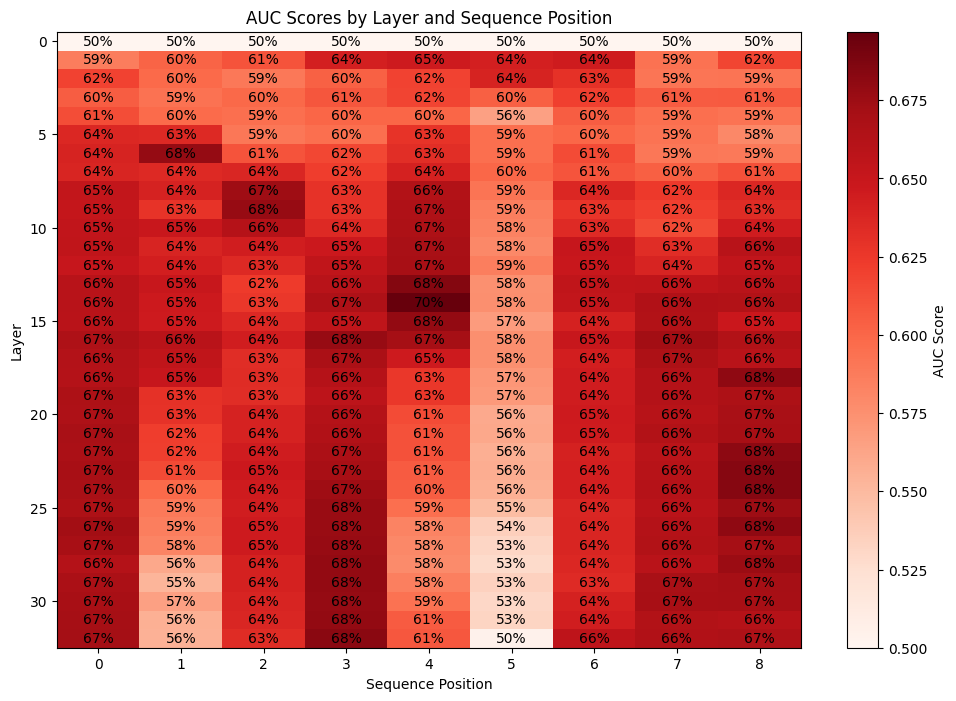

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
im = plt.imshow(auc_scores, cmap="Reds", aspect="auto")
plt.colorbar(im, label="AUC Score")

# Add text annotations
for i in range(auc_scores.shape[0]):  # layers
    for j in range(auc_scores.shape[1]):  # sequence positions
        text = f"{auc_scores[i, j]:.0%}"
        plt.text(
            j,
            i,
            text,
            ha="center",
            va="center",
            color="black" if auc_scores[i, j] < 0.7 else "white",
        )

plt.xlabel("Sequence Position")
plt.ylabel("Layer")
plt.title("AUC Scores by Layer and Sequence Position")
plt.show()

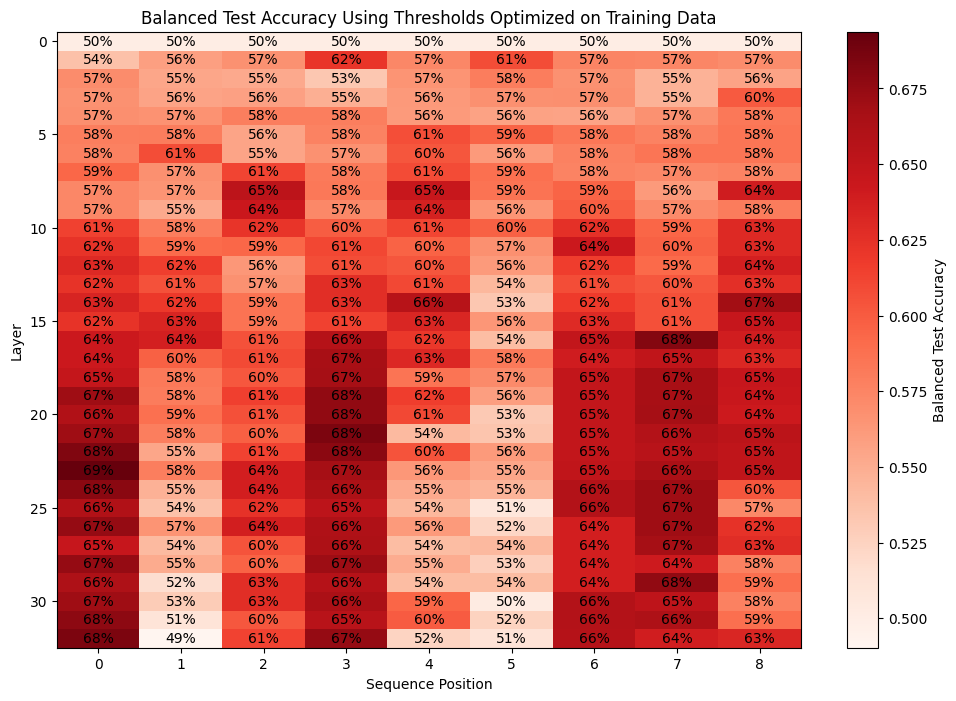

Max balanced test accuracy: 69.4%
Mean balanced test accuracy: 60.1%


In [23]:
# Calculate balanced accuracy for each (layer, seq) position
n_layers, n_seq = fai_test_acts.shape[1:]
acc_scores = torch.zeros((n_layers, n_seq))
best_thresholds = torch.zeros((n_layers, n_seq))

# First find optimal thresholds on training data
for layer in range(n_layers):
    for seq in range(n_seq):
        # Get training scores for this position
        fai_scores = fai_train_acts[:, layer, seq].cpu().numpy()
        unf_scores = unf_train_acts[:, layer, seq].cpu().numpy()

        # Try all possible thresholds from training scores
        all_scores = np.concatenate([fai_scores, unf_scores])
        thresholds = np.sort(all_scores)

        # True labels for training data
        y_true = np.concatenate([np.ones(len(fai_scores)), np.zeros(len(unf_scores))])

        # Find best threshold on training data
        best_acc = 0
        best_threshold = 0
        for threshold in thresholds:
            y_pred = (all_scores >= threshold).astype(int)

            # Calculate balanced accuracy (average of sensitivity and specificity)
            true_pos = ((y_pred == 1) & (y_true == 1)).sum()
            true_neg = ((y_pred == 0) & (y_true == 0)).sum()
            sensitivity = true_pos / (y_true == 1).sum()
            specificity = true_neg / (y_true == 0).sum()
            balanced_acc = (sensitivity + specificity) / 2

            if balanced_acc > best_acc:
                best_acc = balanced_acc
                best_threshold = threshold

        # Store best threshold
        best_thresholds[layer, seq] = float(best_threshold)

        # Evaluate on test data using this threshold
        test_fai_scores = fai_test_acts[:, layer, seq].cpu().numpy()
        test_unf_scores = unf_test_acts[:, layer, seq].cpu().numpy()
        test_scores = np.concatenate([test_fai_scores, test_unf_scores])
        test_true = np.concatenate(
            [np.ones(len(test_fai_scores)), np.zeros(len(test_unf_scores))]
        )
        test_pred = (test_scores >= best_threshold).astype(int)

        # Calculate balanced accuracy on test set
        true_pos = ((test_pred == 1) & (test_true == 1)).sum()
        true_neg = ((test_pred == 0) & (test_true == 0)).sum()
        test_sensitivity = true_pos / (test_true == 1).sum()
        test_specificity = true_neg / (test_true == 0).sum()
        test_balanced_acc = (test_sensitivity + test_specificity) / 2

        acc_scores[layer, seq] = test_balanced_acc

# Visualize
plt.figure(figsize=(12, 8))
im = plt.imshow(acc_scores, cmap="Reds", aspect="auto")
plt.colorbar(im, label="Balanced Test Accuracy")

# Add text annotations
for i in range(acc_scores.shape[0]):
    for j in range(acc_scores.shape[1]):
        text = f"{acc_scores[i, j]:.0%}"
        plt.text(
            j,
            i,
            text,
            ha="center",
            va="center",
            color="black" if acc_scores[i, j] < 0.7 else "white",
        )

plt.xlabel("Sequence Position")
plt.ylabel("Layer")
plt.title("Balanced Test Accuracy Using Thresholds Optimized on Training Data")
plt.show()

print(f"Max balanced test accuracy: {acc_scores.max():.1%}")
print(f"Mean balanced test accuracy: {acc_scores.mean():.1%}")